# 4. RNN

In [1]:
# Bibliotecas básicas 
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd 
import seaborn as sns

# Definições estéticas
plt.style.use('ggplot')
color_pal = sns.color_palette()
sns.set(rc={'figure.figsize':(20,10)})

In [2]:
# Base de dados
treino = pd.read_csv('/content/treino.csv')
treino = treino.set_index('Datetime')
treino.index = pd.to_datetime(treino.index)

teste = pd.read_csv('/content/teste.csv')
teste = teste.set_index('Datetime')
teste.index = pd.to_datetime(teste.index)

In [3]:
# Bibliotecas
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras

In [4]:
# Limpar a sessão remove os nós deixados dos modelos anteriores
tf.keras.backend.clear_session()

## 4.1. Preparando os dados

In [5]:
# MinMaxScaler do Sklearn é uma técnica de pré-processamento que coloca os dados na mesma escala. 
# Em tradução livre da documentação: Transforma as features ao deixá-las na mesma escala em um determinado range
scaler = MinMaxScaler()

In [6]:
# Normalização do teste e treino
treino_norm = scaler.fit_transform(treino)
teste_norm = scaler.fit_transform(teste)

In [7]:
# Modifica a serie temporal tornando-a um problema de aprendizado supervisionado
# Isto é feito utilizando um descolamento no array
# Este deslocamento vai causar um atraso nas previsões
# Retornando array de entrada x e de saída y

# Quero utilizar como base uma posição, utilizo o atual para predizer o próximo ponto na sequência
def timeseries_to_supervised_dense(series, look_back=1):
    # o reshape com -1 preenche a dimensão conforme necessário, nesse caso teremos (num_valores, 1)
    x = np.reshape(np.array(series[:-look_back]), (-1, 1))
    y = np.reshape(np.array(series[look_back:]), (-1, 1))
    #y = np.array(series[shift:], copy=True)
    return x, y

## 4.2. MLP

In [8]:
# look back = 1, olhando um para atrás
# Perderei um elemento, olhando no ponto futuro
look_back = 1
treino_x_dense, treino_y_dense = timeseries_to_supervised_dense(treino_norm, look_back=look_back)

# Numero de features na série
no_features = treino_x_dense.shape[1]

In [9]:
# Definir as sementes auxiliam a ter resultados reproduzíveis
seed(1)
set_seed(1)

# Modelo MLP
modelMLP = keras.Sequential()
modelMLP.add(keras.layers.InputLayer((None, no_features)))
modelMLP.add(keras.layers.Dense(16, activation='relu'))
modelMLP.add(keras.layers.Dense(32, activation='relu'))
modelMLP.add(keras.layers.Dropout(0.2))
modelMLP.add(keras.layers.Dense(1, activation='relu'))
modelMLP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 16)          32        
                                                                 
 dense_1 (Dense)             (None, None, 32)          544       
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 dense_2 (Dense)             (None, None, 1)           33        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [10]:
# batch size = 1, cada elemento vai ser utilizado para predizer o próximo e 
#                 esses elementos vão estar em uma certa ordem (série temporal)
batch_size = 1
epochs = 20

# Decaimento de learning rate
def scheduler(epoch, lr):
    if (epoch % 2 == 0): print("Época %04d - learning rate %.9f" % (epoch, lr))
    if (epoch+1 < 5):
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.01),9)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Compilacao e treinamento
modelMLP.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['mae'])

histMLP = modelMLP.fit(treino_x_dense, treino_y_dense,  
                       batch_size=batch_size, 
                       epochs=epochs,
                       callbacks=[callbacklr], 
                       verbose=0)

Época 0000 - learning rate 0.000100000
Época 0002 - learning rate 0.000100000
Época 0004 - learning rate 0.000100000
Época 0006 - learning rate 0.000098020
Época 0008 - learning rate 0.000096079
Época 0010 - learning rate 0.000094177
Época 0012 - learning rate 0.000092312
Época 0014 - learning rate 0.000090484
Época 0016 - learning rate 0.000088693
Época 0018 - learning rate 0.000086936


Scores treinamento
MSE: 0.0014
MAE: 0.0281


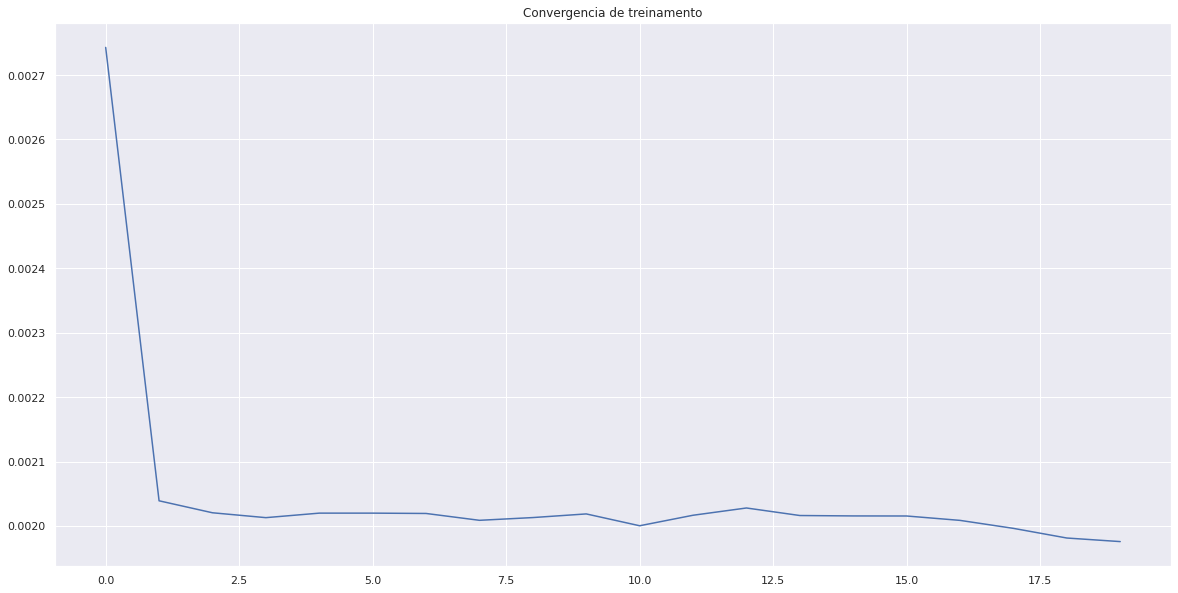

In [11]:
scores = modelMLP.evaluate(treino_x_dense, treino_y_dense, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0])) # Erro Quadrático Médio (Mean squared error)
print('MAE: %.4f' % (scores[1])) # Erro médio absoluto (Mean absolute error)

plt.plot(histMLP.history['loss'])
ax = plt.title('Convergencia de treinamento')

In [12]:
# Também preciso colocar os dados de teste na ideia de dados supervisionados
# Também perco 1
teste_x_dense, teste_y_dense = timeseries_to_supervised_dense(teste_norm, look_back=look_back)

In [13]:
# Realiza predicoes com os dados de treinamento e teste
treino_y_predMLP = modelMLP.predict(treino_x_dense)
treino_y_predMLP = np.reshape(treino_y_predMLP, (-1, 1))[1:] # array dentro do outro -> refaço o formato para pegar os elementos
                                                             # apredição está um para frente

teste_y_predMLP = modelMLP.predict(teste_x_dense)
teste_y_predMLP = np.reshape(teste_y_predMLP, (-1, 1))[1:]

983/983 [==============================] - 2s 2ms/step


In [14]:
print("Tamanho do teste:", len(teste))
print("Tamanho do teste predito MLP:", len(teste_y_predMLP))

Tamanho do teste: 31429
Tamanho do teste predito MLP: 31427


In [15]:
# 'Desnormaliza' os valores
teste_y_predMLP = scaler.inverse_transform(teste_y_predMLP)

In [16]:
# reshape(-1): 'whatever it takes' to flatten
#              A common use case is to flatten a nested array of an unknown number of elements to a 1D array.
teste_y_predMLP = teste_y_predMLP.reshape(-1)

In [17]:
# Transformando para uma coluna DataFrame
teste_dense = pd.DataFrame(teste_y_predMLP, columns = ['MLP'])

In [18]:
# Adicionando a coluna 'Dense' ao DataFrame teste
teste = teste.reset_index()
teste = pd.concat([teste, teste_dense], axis=1)

In [19]:
# Retornando o 'Datetime' como index
teste = teste.set_index('Datetime')
teste.index = pd.to_datetime(teste.index)

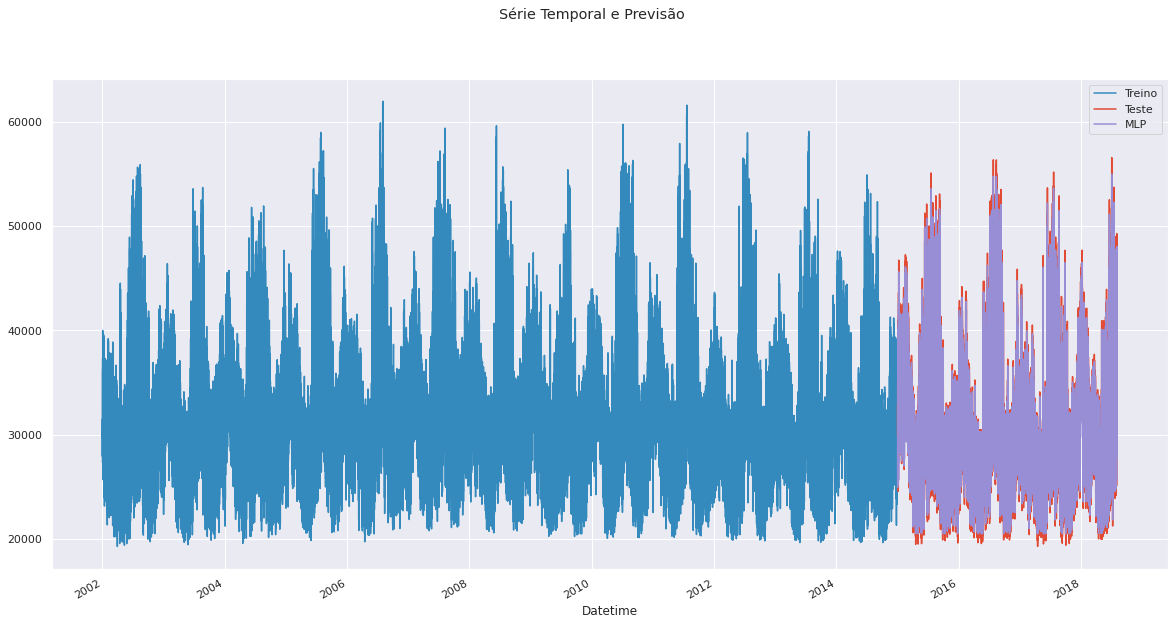

In [20]:
# Plotando o gráfco
treino['PJME_MW'].plot(legend=True, label='Treino', color=color_pal[1]) 
teste['PJME_MW'].plot(legend=True, label='Teste', color=color_pal[0])

teste['MLP'].plot(legend=True, label='MLP', color=color_pal[2])

plot = plt.suptitle('Série Temporal e Previsão')

In [21]:
# Salvando o modelo MLP
modelMLP.save('MLP_model.h5')

## 4.3. LSTM

In [22]:
# Limpar a sessão remove os nós deixados dos modelos anteriores
tf.keras.backend.clear_session()

### Utilizando LSTMs para predição

Agora utilizaremos uma rede neural baseada em camada recorrente, permitindo aprender a sequência.

Uma camada LSTM espera como entrada uma matriz (um tensor, mais precisamente) com as seguintes dimensões:

samples x time_steps x features

* *Samples* são as observações independentes do domínio, tipicamente colunas de dados, consideradas no batch

* *Time steps* são os passos temporais separados de uma dada variável para uma dada observação - quantas observações serão dadas como entrada antes de que a primeira saída seja obtida (quantos elementos estou olhando para predizer o próximo; a MLP só permitia 1)

* *Features* são as medidas separadas observada em cada tempo da observação - quantos valores são considerados em cada entrada

No caso dessa base de dados, podemos usar diferentes configurações. Para manter simples, consideramos que o problema em cada passo de tempo é uma amostra individual, com um time step e uma feature apenas.


In [23]:
# Formato deve ser [samples, time steps, features]
def recurrent_array(train_x,time_steps=1):
    
    array = np.array(np.reshape(train_x, (-1, 1)), copy=True)
    
    train_y_ts = array[time_steps:]
    train_x_ts = []
    for i in range(0, len(array) - time_steps):
        train_x_ts.append(array[i:i+time_steps])
        
    train_x_ts = np.array(train_x_ts)
    
    #rec_array = np.reshape(array, (array.shape[0], time_steps, array.shape[1]))
    return train_x_ts, train_y_ts

In [24]:
# Estou olhando dois elementos para predizer o próximo
time_steps = 2

# Utilizando a função
treino_x_rec, treino_y_rec = recurrent_array(treino_norm, time_steps=time_steps)
teste_x_rec, teste_y_rec = recurrent_array(teste_norm,time_steps=time_steps)

Posso utilizar time_steps=1?


Sim, pode. Mas na implementação de uma rede recorrente, quando eu uso time_steps=1 ele não utiliza a memória da LSTM. 

Vai funcionar muito parecido com duas camadas MLP.
Quando uso time_steps=2, o sumário criado para o primeiro, vai para o segundo.

In [25]:
# Definir as sementes auxiliam a ter resultados reproduzíveis
seed(1)
set_seed(1)

# Cada elemento vai ser utilizado para predizer o próximo e esses elementos vão estar em uma certa ordem (série temporal)
batch_size = 1

# Modelo LSTM
modelLSTM = keras.models.Sequential()
modelLSTM.add(keras.layers.InputLayer((None, no_features)))
modelLSTM.add(keras.layers.LSTM(16, return_sequences=True, activation='relu')) # 32
modelLSTM.add(keras.layers.LSTM(32, activation='relu'))
modelLSTM.add(keras.layers.Dropout(0.2))
modelLSTM.add(keras.layers.Dense(1, activation='relu'))
modelLSTM.summary()

# return_sequences=True, retorna o sumário para a próxima camada
# se não quero passar o sumário, só quero passar a a saída, return_sequences=False
# se há duas camadas LSTM seguidas, preciso colocar return_sequences=True

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 16)          1152      
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 7,457
Trainable params: 7,457
Non-trainable params: 0
_________________________________________________________________


In [26]:
epochs = 20

# Decaimento de learning rate
def scheduler(epoch, lr):
    if (epoch % 2 == 0): print("Época %04d - learning rate %.9f" % (epoch, lr))
    if (epoch+1 < 5):
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.01),9)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Compilacao e treinamento
modelLSTM.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['mae'])

histLSTM = modelLSTM.fit(treino_x_rec, treino_y_rec,  
                         batch_size=batch_size, 
                         epochs=epochs,
                         callbacks=[callbacklr], 
                         shuffle=False,
                         verbose=0)

Época 0000 - learning rate 0.000100000
Época 0002 - learning rate 0.000100000
Época 0004 - learning rate 0.000100000
Época 0006 - learning rate 0.000098020
Época 0008 - learning rate 0.000096079
Época 0010 - learning rate 0.000094177
Época 0012 - learning rate 0.000092312
Época 0014 - learning rate 0.000090484
Época 0016 - learning rate 0.000088693
Época 0018 - learning rate 0.000086936


Scores treinamento
MSE: 0.0007
MAE: 0.0202


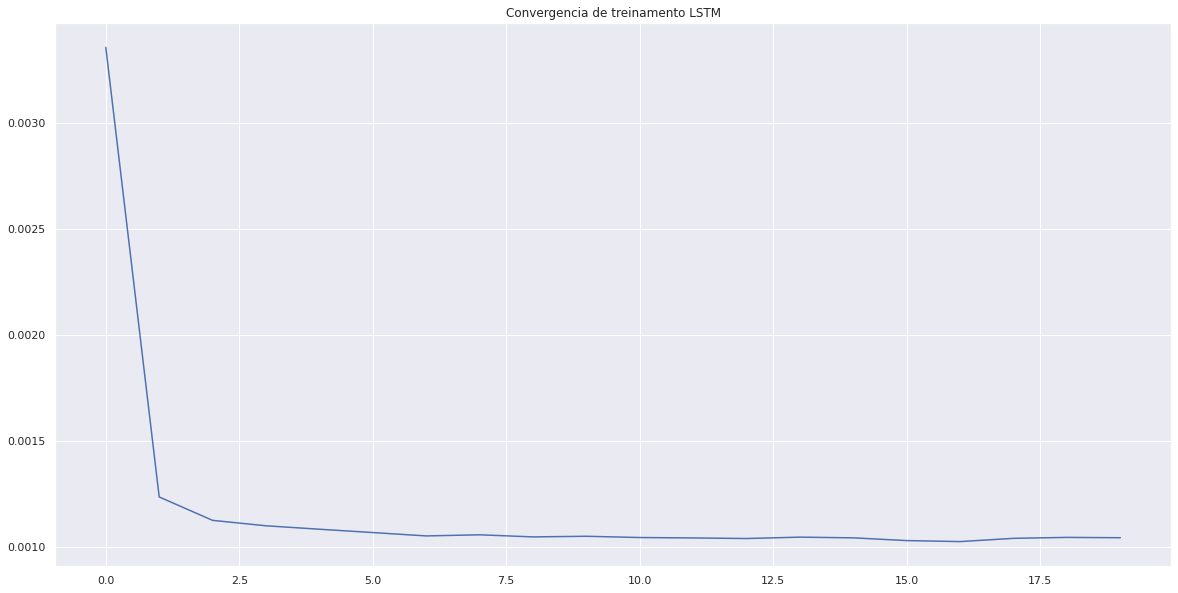

In [27]:
scores = modelLSTM.evaluate(treino_x_rec, treino_y_rec, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0])) # Erro Quadrático Médio (Mean squared error)
print('MAE: %.4f' % (scores[1])) # Erro médio absoluto (Mean absolute error)

plt.plot(histLSTM.history['loss'])
ax = plt.title('Convergencia de treinamento LSTM')

In [28]:
# Realiza predicoes com os dados de treinamento e teste
treino_y_predLSTM = modelLSTM.predict(treino_x_rec)
treino_y_predLSTM = np.reshape(treino_y_predLSTM, (-1, 1))[time_steps:]

teste_y_predLSTM = modelLSTM.predict(teste_x_rec)
teste_y_predLSTM = np.reshape(teste_y_predLSTM, (-1, 1))[time_steps:]

983/983 [==============================] - 2s 2ms/step


In [29]:
print("Tamanho do teste:", len(teste))
print("Tamanho do teste predito LSTM:", len(teste_y_predLSTM))

Tamanho do teste: 31429
Tamanho do teste predito LSTM: 31425


In [30]:
# 'Desnormaliza' os valores
teste_y_predLSTM = scaler.inverse_transform(teste_y_predLSTM)

In [31]:
# reshape(-1): 'whatever it takes' to flatten
#              A common use case is to flatten a nested array of an unknown number of elements to a 1D array.
teste_y_predLSTM = teste_y_predLSTM.reshape(-1)

In [32]:
# Transformando para uma coluna DataFrame
teste_lstm = pd.DataFrame(teste_y_predLSTM, columns = ['LSTM'])

In [33]:
# Adicionando a coluna 'Dense' ao DataFrame teste
teste = teste.reset_index()
teste = pd.concat([teste, teste_lstm], axis=1)

In [34]:
# Retornando o 'Datetime' como index
teste = teste.set_index('Datetime')
teste.index = pd.to_datetime(teste.index)

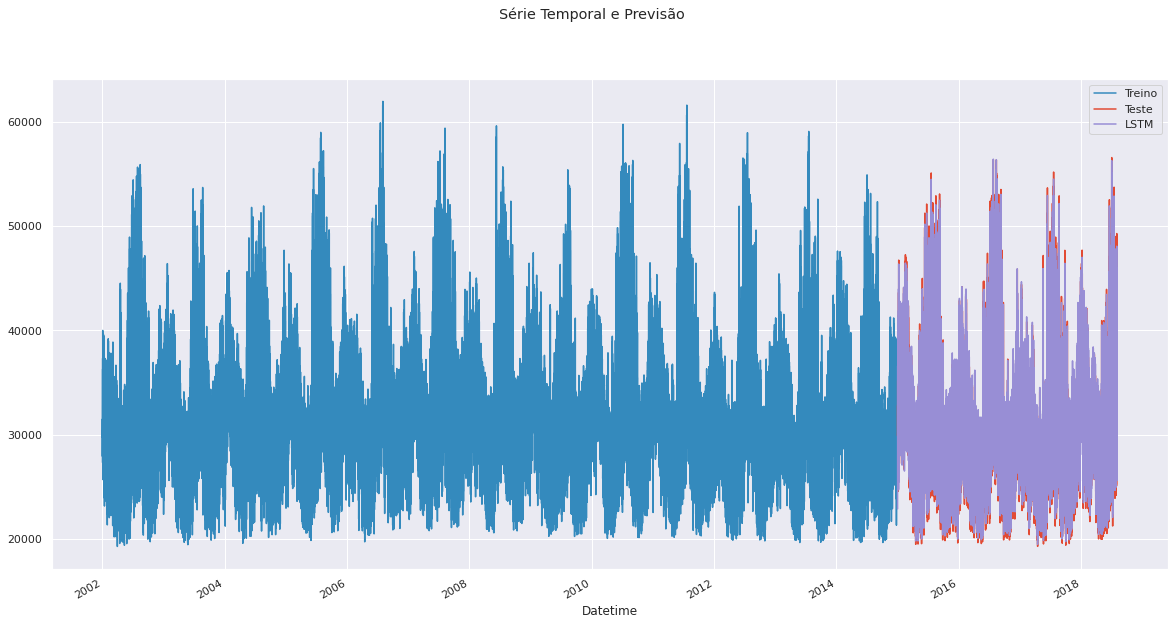

In [35]:
# Plotando o gráfco
treino['PJME_MW'].plot(legend=True, label='Treino', color=color_pal[1]) 
teste['PJME_MW'].plot(legend=True, label='Teste', color=color_pal[0])

teste['LSTM'].plot(legend=True, label='LSTM', color=color_pal[2])

plot = plt.suptitle('Série Temporal e Previsão')

In [36]:
# Salvando modelo LSTM
modelLSTM.save('LSTM_model.h5')

## 4.4. GRU

In [37]:
# Limpar a sessão remove os nós deixados dos modelos anteriores
tf.keras.backend.clear_session()

In [38]:
# Definir as sementes auxiliam a ter resultados reproduzíveis
seed(1)
set_seed(1)

# Cada elemento vai ser utilizado para predizer o próximo e esses elementos vão estar em uma certa ordem (série temporal)
batch_size = 1

# Modelo GRU
modelGRU = keras.models.Sequential()
modelGRU.add(keras.layers.InputLayer((None, no_features)))
modelGRU.add(keras.layers.GRU(16, return_sequences=True, activation='relu'))
modelGRU.add(keras.layers.GRU(32, activation='relu'))
modelGRU.add(keras.layers.Dropout(0.2))
modelGRU.add(keras.layers.Dense(1, activation='relu'))
modelGRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 16)          912       
                                                                 
 gru_1 (GRU)                 (None, 32)                4800      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,745
Trainable params: 5,745
Non-trainable params: 0
_________________________________________________________________


In [39]:
epochs = 20

# decaimento de learning rate
def scheduler(epoch, lr):
    if (epoch % 2 == 0): print("Época %04d - learning rate %.9f" % (epoch, lr))
    if (epoch+1 < 5):
        return lr
    else:
        return np.round(lr * tf.math.exp(-0.01),9)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Compilacao e treinamento
modelGRU.compile(loss='mean_squared_error', 
            optimizer=keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['mae'])

histGRU = modelGRU.fit(treino_x_rec, treino_y_rec,  
                      batch_size=batch_size, 
                      epochs=epochs,
                      callbacks=[callbacklr], 
                      shuffle=False,
                      verbose=0)

Época 0000 - learning rate 0.000100000
Época 0002 - learning rate 0.000100000
Época 0004 - learning rate 0.000100000
Época 0006 - learning rate 0.000098020
Época 0008 - learning rate 0.000096079
Época 0010 - learning rate 0.000094177
Época 0012 - learning rate 0.000092312
Época 0014 - learning rate 0.000090484
Época 0016 - learning rate 0.000088693
Época 0018 - learning rate 0.000086936


Scores treinamento
MSE: 0.0008
MAE: 0.0219


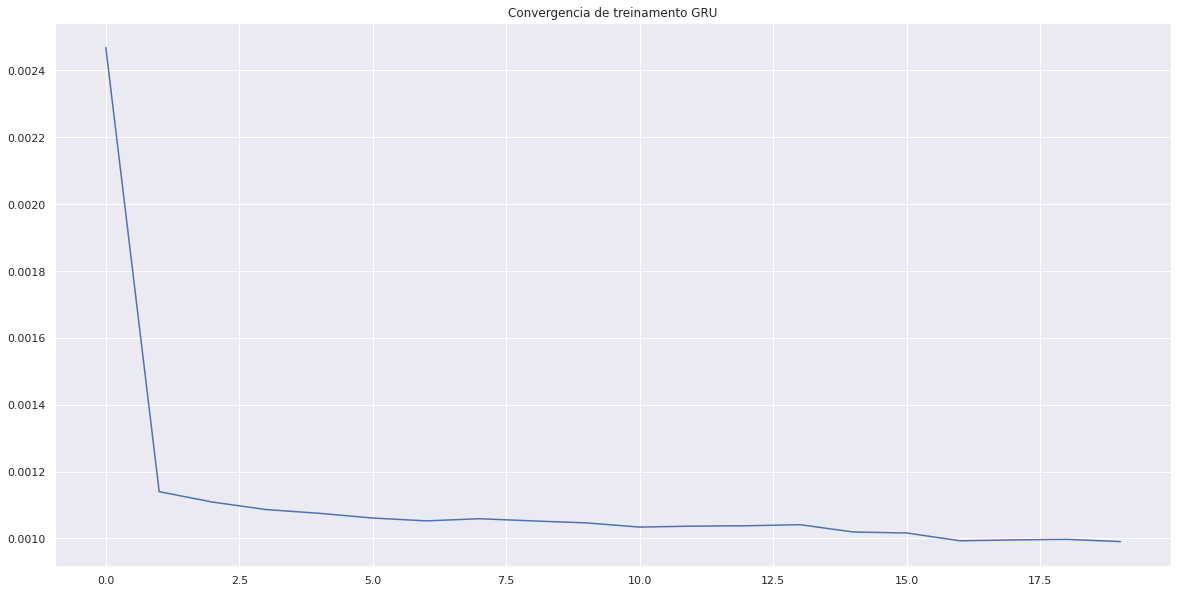

In [40]:
scores = modelGRU.evaluate(treino_x_rec, treino_y_rec, verbose=0)
print('Scores treinamento')
print('MSE: %.4f' % (scores[0])) # Erro Quadrático Médio (Mean squared error)
print('MAE: %.4f' % (scores[1])) # Erro médio absoluto (Mean absolute error)

plt.plot(histGRU.history['loss'])
ax = plt.title('Convergencia de treinamento GRU')

In [41]:
# Realiza predicoes com os dados de treinamento e teste
treino_y_predGRU = modelGRU.predict(treino_x_rec)
treino_y_predGRU = np.reshape(treino_y_predGRU, (-1, 1))[time_steps:]

teste_y_predGRU = modelGRU.predict(teste_x_rec)
teste_y_predGRU = np.reshape(teste_y_predGRU, (-1, 1))[time_steps:]

983/983 [==============================] - 2s 2ms/step


In [42]:
print("Tamanho do teste:", len(teste))
print("Tamanho do teste predito GRU:", len(teste_y_predGRU))

Tamanho do teste: 31429
Tamanho do teste predito GRU: 31425


In [43]:
# 'Desnormaliza' os elementos
test_y_pred = scaler.inverse_transform(teste_y_predGRU)

In [44]:
# reshape(-1): 'whatever it takes' to flatten
#              A common use case is to flatten a nested array of an unknown number of elements to a 1D array.
test_y_pred = test_y_pred.reshape(-1)

In [45]:
# Transformando para uma coluna DataFrame
teste_gru = pd.DataFrame(test_y_pred, columns = ['GRU'])

In [46]:
# Adicionando a coluna 'Dense' ao DataFrame teste
teste = teste.reset_index()
teste = pd.concat([teste, teste_gru], axis=1)

In [47]:
# Retornando o 'Datetime' como index
teste = teste.set_index('Datetime')
teste.index = pd.to_datetime(teste.index)

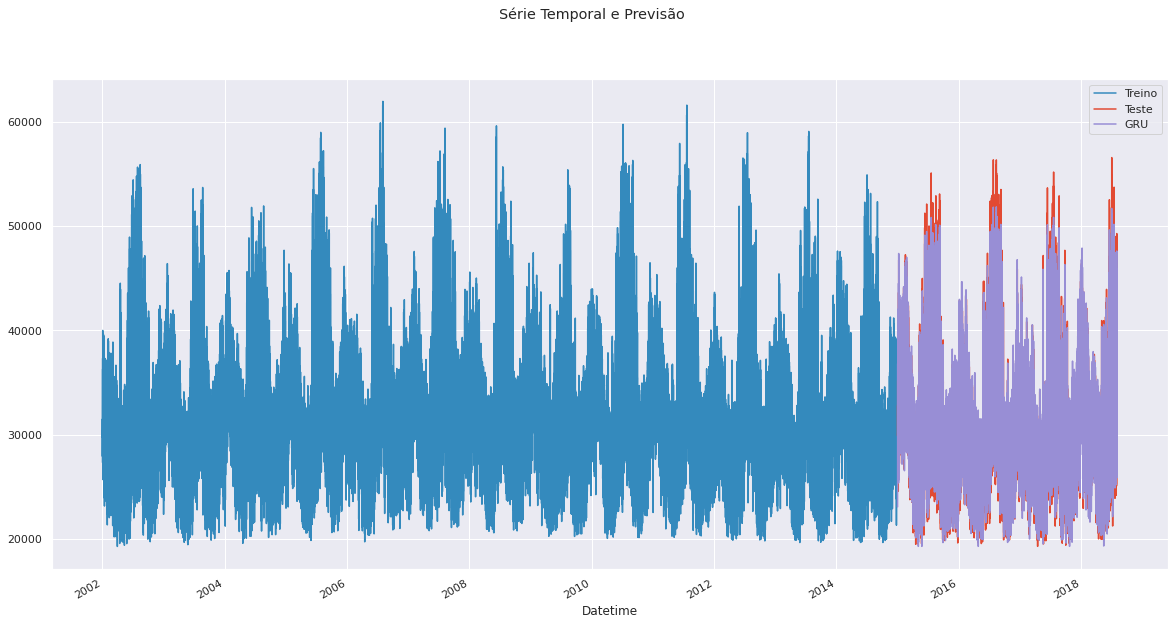

In [48]:
# Plotando o gráfco
treino['PJME_MW'].plot(legend=True, label='Treino', color=color_pal[1]) 
teste['PJME_MW'].plot(legend=True, label='Teste', color=color_pal[0])

teste['GRU'].plot(legend=True, label='GRU', color=color_pal[2])

plot = plt.suptitle('Série Temporal e Previsão')

In [49]:
modelGRU.save('GRU_model.h5')

## 4.5. Comparando valores preditos

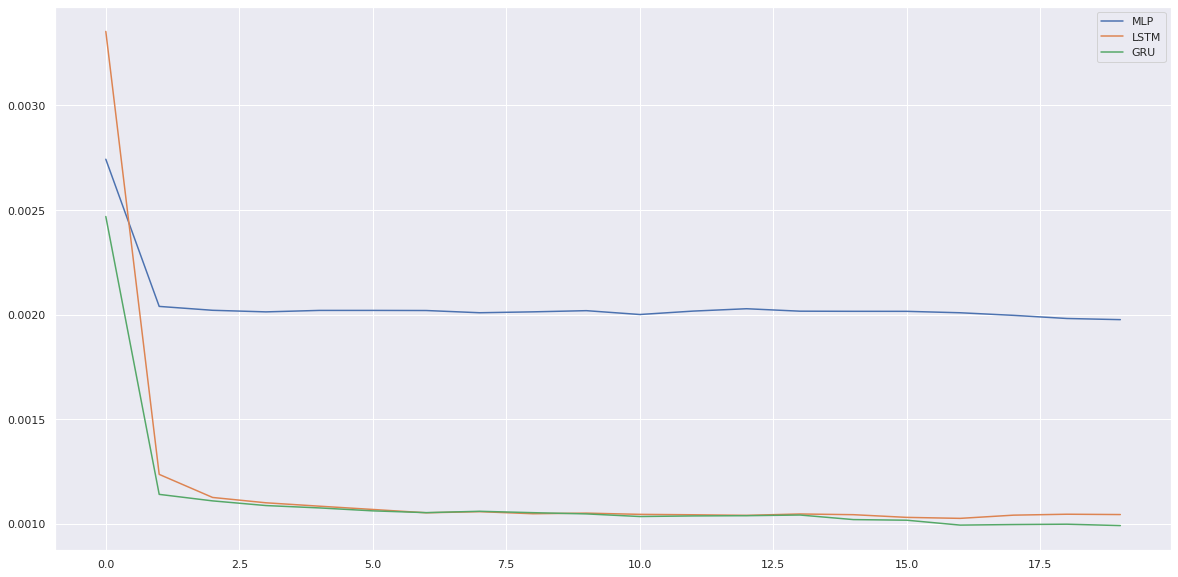

In [50]:
plt.plot(histMLP.history['loss'])
plt.plot(histLSTM.history['loss'])
plt.plot(histGRU.history['loss'])
plt.legend(['MLP', 'LSTM', 'GRU'])

In [51]:
# Avaliacao da predição ponto a ponto
print("Erro no teste com predição a cada ponto:")
scoreMLP = modelMLP.evaluate(teste_x_dense, teste_y_dense, verbose=0)
print("MLP: %.5f" % (scoreMLP[0]))
scoreLSTM = modelLSTM.evaluate(teste_x_rec, teste_y_rec, verbose=0)
print("LSTM: %.5f" % (scoreLSTM[0]))
scoreGRU = modelGRU.evaluate(teste_x_rec, teste_y_rec, verbose=0)
print("GRU: %.5f" % (scoreGRU[0]))

Erro no teste com predição a cada ponto:
MLP: 0.00171
LSTM: 0.00087
GRU: 0.00098


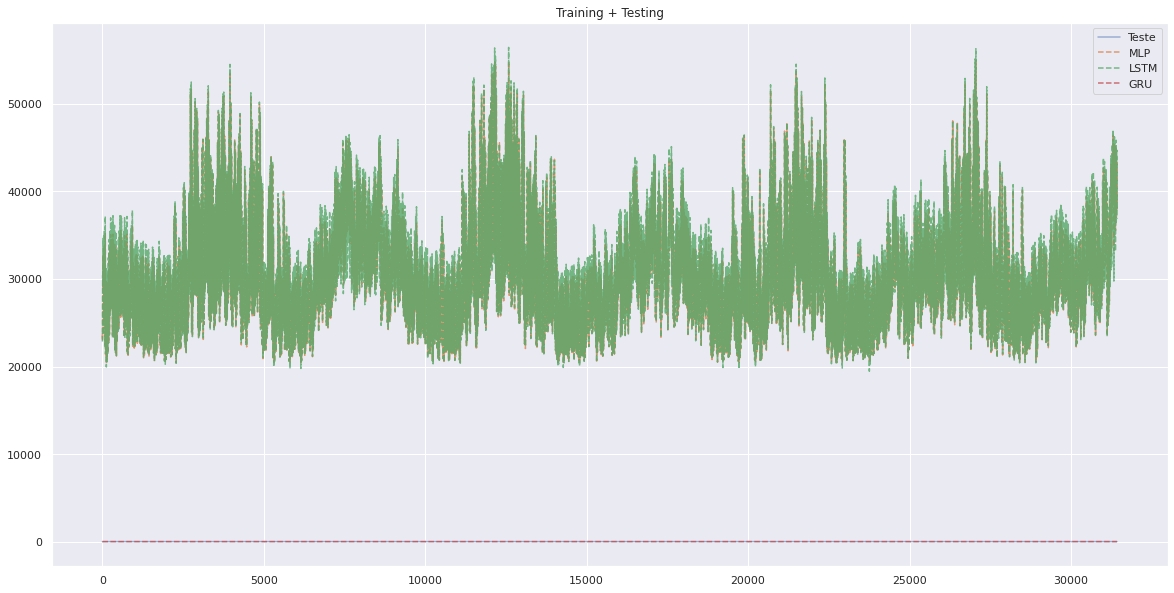

In [52]:
plt.plot(teste_y_dense[time_steps:], '-', alpha=0.5, label='Teste')
plt.plot(teste_y_predMLP[time_steps-1:], '--', alpha=0.8, label='MLP')
plt.plot(teste_y_predLSTM, '--', alpha=0.8, label='LSTM')
plt.plot(teste_y_predGRU, '--', alpha=0.8, label='GRU')
plt.legend()
axt = plt.title('Training + Testing')
plt.show()

## 4.6. Exportando valores preditos

In [53]:
# Bibliotecas
import csv
from google.colab import files

In [54]:
teste.tail()

,PJME_MW,MLP,LSTM,GRU
Datetime,,,,
2018-01-01 20:00:00,44284.0,42762.406250,36871.960938,37053.523438
2018-01-01 21:00:00,43751.0,41476.667969,NaN,NaN
2018-01-01 22:00:00,42402.0,39339.562500,NaN,NaN
2018-01-01 23:00:00,40164.0,NaN,NaN,NaN
2018-01-02 00:00:00,38608.0,NaN,NaN,NaN


In [55]:
teste.loc[:, 'MLP'] = teste.MLP.shift(2)

In [56]:
teste.loc[:, 'LSTM'] = teste.LSTM.shift(4)

In [57]:
teste.loc[:, 'GRU'] = teste.GRU.shift(4)

In [58]:
teste.head()

,PJME_MW,MLP,LSTM,GRU
Datetime,,,,
2015-01-01 00:00:00,32802.0,NaN,NaN,NaN
2015-12-31 01:00:00,24305.0,NaN,NaN,NaN
2015-12-31 02:00:00,23156.0,24897.216797,NaN,NaN
2015-12-31 03:00:00,22514.0,23810.498047,NaN,NaN
2015-12-31 04:00:00,22330.0,23145.341797,22854.515625,23045.179688


In [59]:
teste.tail()

,PJME_MW,MLP,LSTM,GRU
Datetime,,,,
2018-01-01 20:00:00,44284.0,43319.769531,43149.484375,42960.871094
2018-01-01 21:00:00,43751.0,43266.281250,42842.207031,42674.832031
2018-01-01 22:00:00,42402.0,42762.406250,41947.628906,41769.734375
2018-01-01 23:00:00,40164.0,41476.667969,39852.191406,39850.960938
2018-01-02 00:00:00,38608.0,39339.562500,36871.960938,37053.523438


In [60]:
# Transformando para csv
teste.to_csv('teste_rnn.csv')

In [62]:
# A célula anterior deixa o csv na máquina virtual
# Para guardar na computador
files.download("teste_rnn.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>